In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=(8, 4))
plt.style.use('seaborn-v0_8-bright')

import cartopy.crs as ccrs

import GRACE_data_functions as grace_tools
import GNSS_data_functions as gnss_tools

# I. Load data
## A. GNSS data

In [24]:
gnss_data_dir = "../GNSS_data"
gnss_df,stations = gnss_tools.load_GNSS_tenv_data(gnss_data_dir)

print("\nStations chargées :")
for station,(lat,lon) in stations.items():
    print(f"{station} lat={lat:.1f}° lon={lat:.1f}°")

Station AMCO : 230 outliers removed.
Station MTCO : 22 outliers removed.
Station PAIT : 81 outliers removed.
Station MABA : 80 outliers removed.
Station TTUW : 48 outliers removed.
Station SAGA : 213 outliers removed.
Station IMCH : 26 outliers removed.

Stations chargées :
AMCO lat=-4.9° lon=-4.9°
MTCO lat=-10.8° lon=-10.8°
PAIT lat=-4.3° lon=-4.3°
MABA lat=-5.4° lon=-5.4°
TTUW lat=10.6° lon=10.6°
SAGA lat=-0.1° lon=-0.1°
IMCH lat=-38.4° lon=-38.4°


[]

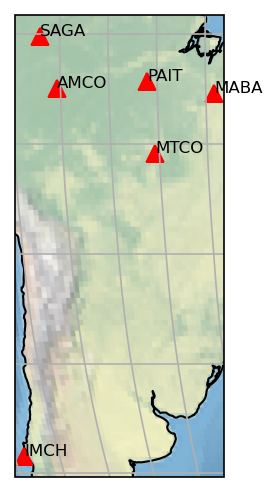

In [20]:
# Plot sur une cartes des stations GNSS étudiées
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, dpi=150)

# Tracer les points sur la carte avec les codes en label
for code, (lat, lon) in stations.items():
    ax.plot(lon, lat, '^', markersize=8, color='red', transform=ccrs.Geodetic())
    ax.text(lon, lat, code, transform=ccrs.Geodetic(), fontsize=8, color='black')

# Ajouter les caractéristiques de la carte
# ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()

# plt.savefig("../figures/stations_locations.png", dpi=200.)
plt.plot()

## B. GRACE data

In [21]:
# Recherche des fichiers des données et extraction de la date à partir du nom

pattern = re.compile(r'(\d{4})(\d{3})-(\d{4})(\d{3})')

table_corres = {}

liste_files = os.listdir("../GRACE_data/")
liste_files.sort()

for fichier in liste_files:
    
    # Appliquer la regex sur le nom de fichier
    match = pattern.search(fichier)
    
    if match:
        # Extraire les parties YYYY et DDD
        annee1, jour_de_l_annee1, annee2, jour_de_l_annee2 = match.groups()
            
        # Convertir en date pour les deux champs
        date1_str = f"{annee1}-{jour_de_l_annee1}"
        date1 = datetime.strptime(date1_str, "%Y-%j").date()
        
        date2_str = f"{annee2}-{jour_de_l_annee2}"
        date2 = datetime.strptime(date2_str, "%Y-%j").date()
        
        table_corres[date1 + (date1-date2)/2] = fichier

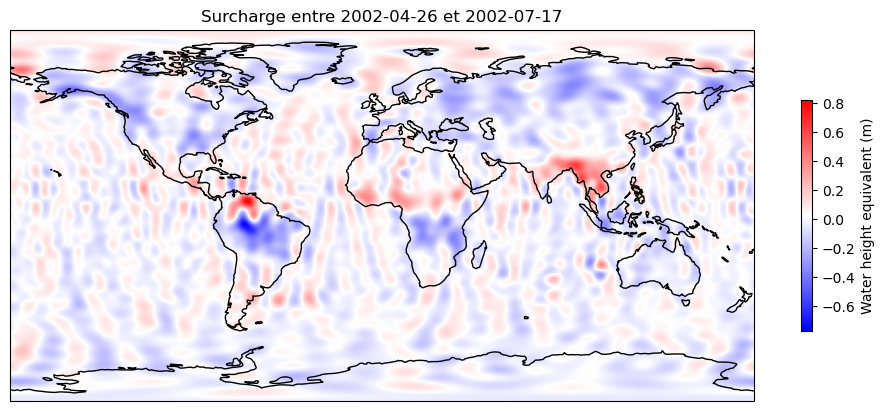

In [9]:
# 1. Calcul anomalie

file_1,file_2 = list(table_corres.values())[1:3]
dt1,dt2 = list(table_corres.keys())[1:3]

Clm_0 = grace_tools.read_grace_file("../GRACE_data/"+file_1)
Clm_1 = grace_tools.read_grace_file("../GRACE_data/"+file_2)

# 2. Filtre DDK5

dClm = grace_tools.filter_DDK5(Clm_1-Clm_0)

# 3. Hauteur d'eau équivalente
dHlm = grace_tools.dClm_to_Hlm(dClm)

# 3. Décomposition HS déplacement

Ulm,N1lm,N2lm,Elm = grace_tools.dClm_to_UN1N2Elm(dClm)

# 4. Passage en grille lat lon

lon = np.arange(-179.5, 180, 1)
lat = np.arange(-89.5, 90, 1)

(lon, lat) = np.meshgrid(lon, lat)

# Les latitudes en radians
phi = np.pi/180*lat

# dE = Elm.expand(lon=lon, lat=lat)/np.cos(phi)
# dN = N1lm.expand(lon=lon, lat=lat)*np.tan(phi) + N2lm.expand(lon=lon, lat=lat)/np.cos(phi)
# dU = Ulm.expand(lon=lon, lat=lat)

dH = dHlm.expand(lon=lon, lat=lat)

fig,ax,cbar = grace_tools.plot_cartopy(lat, lon, dH[::-1,:])
cbar.set_label("Water height equivalent (m)")
ax.set_title(f"Surcharge entre {dt1} et {dt2}")

# fig.savefig("../figures/dh_map_example.png", dpi=100)
plt.show()

In [25]:
# Pour chaque station GNSS : calcul du déplacement à chaque date par rapport à la première mesure des données
    
file_0 = list(table_corres.values())[0]
Clm_0 = grace_tools.read_grace_file("../GRACE_data/"+file_0)

lons,lats = [],[]
for lat,lon in stations.values():
    lons.append(lon)
    lats.append(lat)
(lons, lats) = (np.array(lons), np.array(lats))
phi = np.pi/180*lats

code_stations = stations.keys()
dates = table_corres.keys()

multi_index = pd.MultiIndex.from_product([code_stations, dates], names=['Station', 'Date'])

grace_df = pd.DataFrame(np.zeros((len(multi_index),3)), index=multi_index, columns=['up', 'north', 'east'])

for date in dates : 

    Clm = grace_tools.read_grace_file("../GRACE_data/"+table_corres[date])
    dClm = grace_tools.filter_DDK5(Clm-Clm_0)

    Ulm,N1lm,N2lm,Elm = grace_tools.dClm_to_UN1N2Elm(dClm)

    dE = Elm.expand(lon=lons, lat=lats)/np.cos(phi)
    dN = N1lm.expand(lon=lons, lat=lats)*np.tan(phi) + N2lm.expand(lon=lon, lat=lat)/np.cos(phi)
    dU = Ulm.expand(lon=lons, lat=lats)

    for i,code in enumerate(stations.keys()):
        
        grace_df.loc[(code,date),"up"] = dU[i]
        grace_df.loc[(code,date),"north"] = dN[i]
        grace_df.loc[(code,date),"east"] = dE[i]

In [11]:
# Chargement du fichier de discontinuités 

gnss_steps = pd.read_fwf("../GNSS_data/steps_gnss_stations.txt")
gnss_steps.columns = ["Station", "YYMMMDD", "Code", "Description"]

gnss_steps["Date"] = gnss_steps["YYMMMDD"].apply(lambda x: datetime.strptime(x, "%y%b%d"))

gnss_steps = gnss_steps[["Station", "Date", "Description"]].set_index("Station")


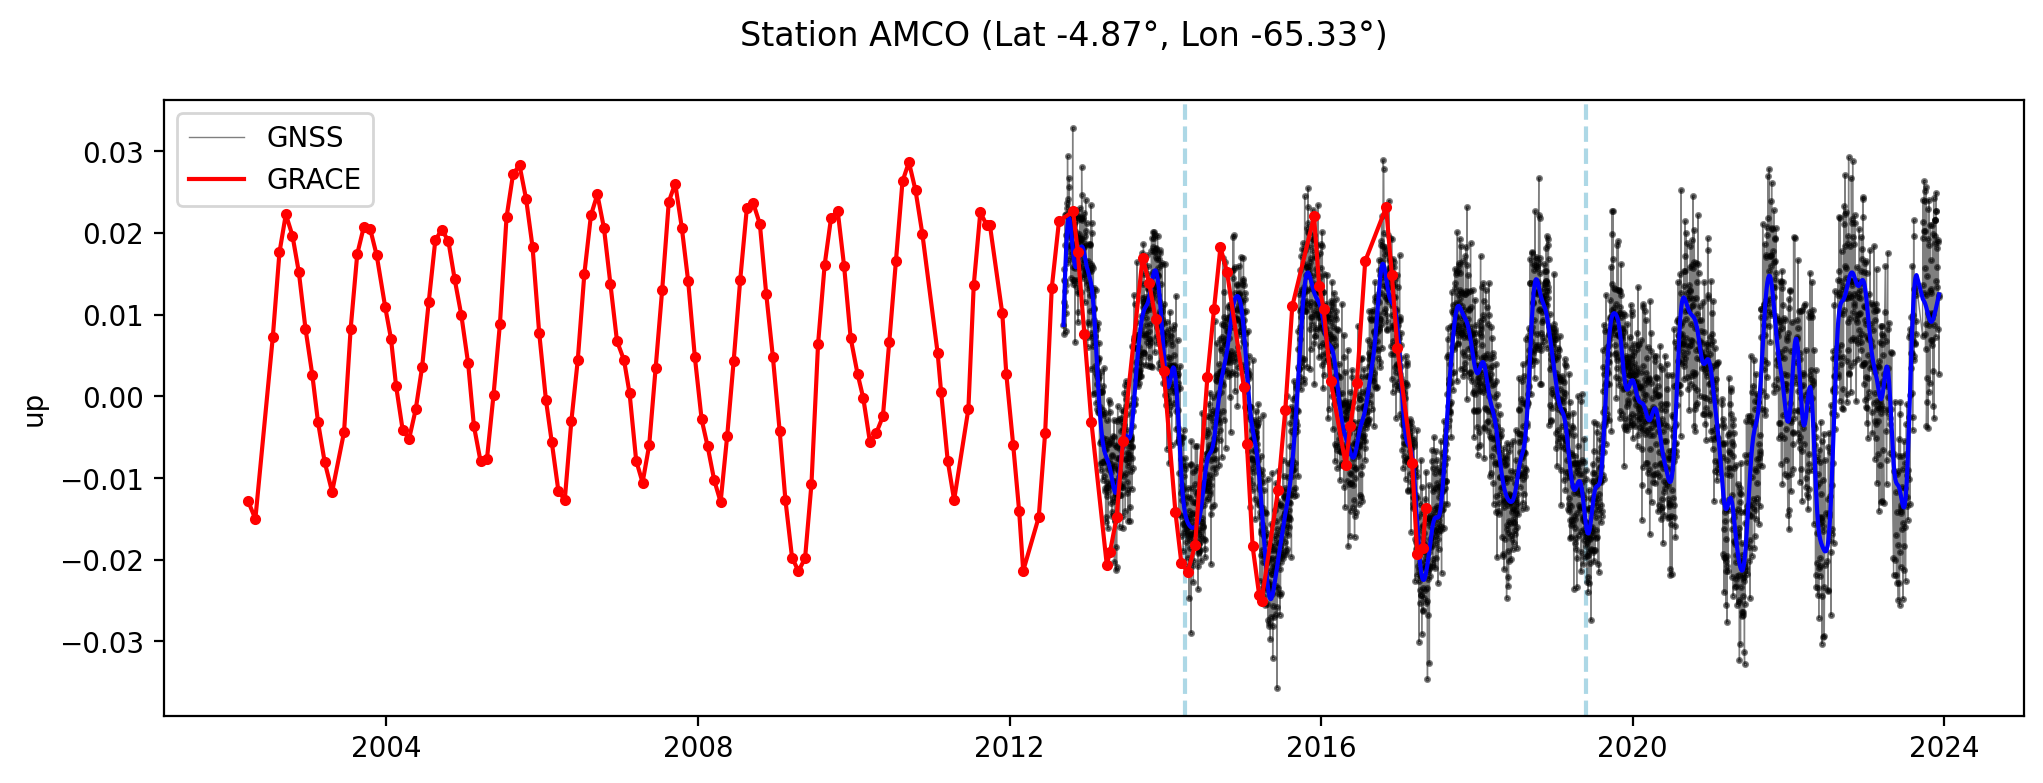

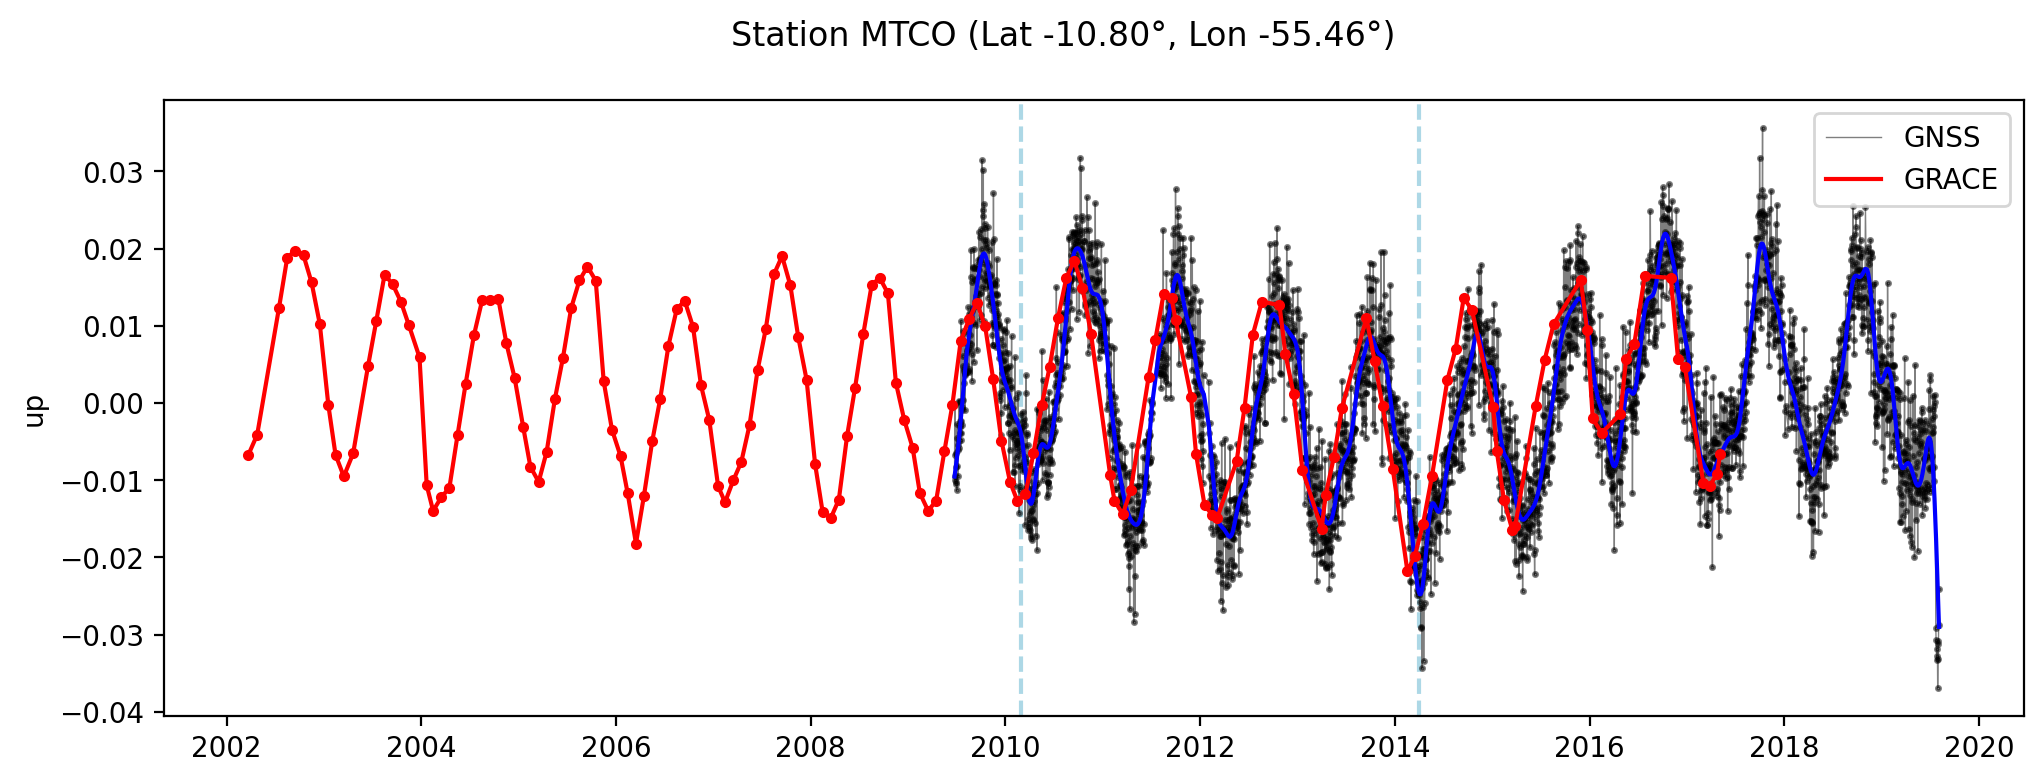

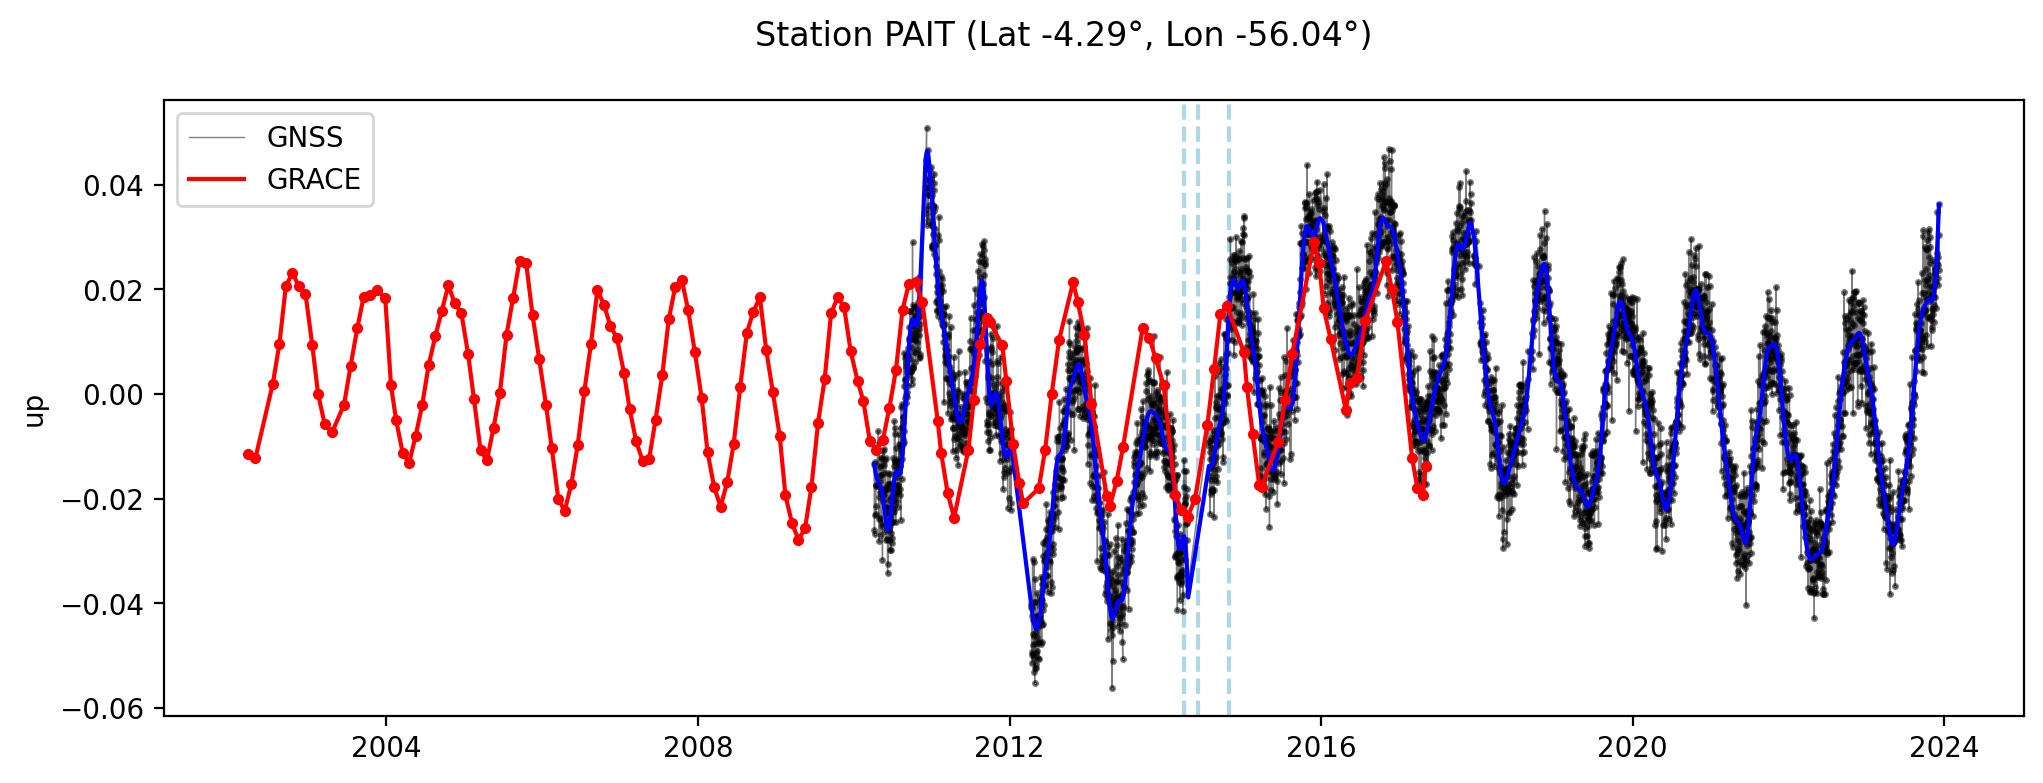

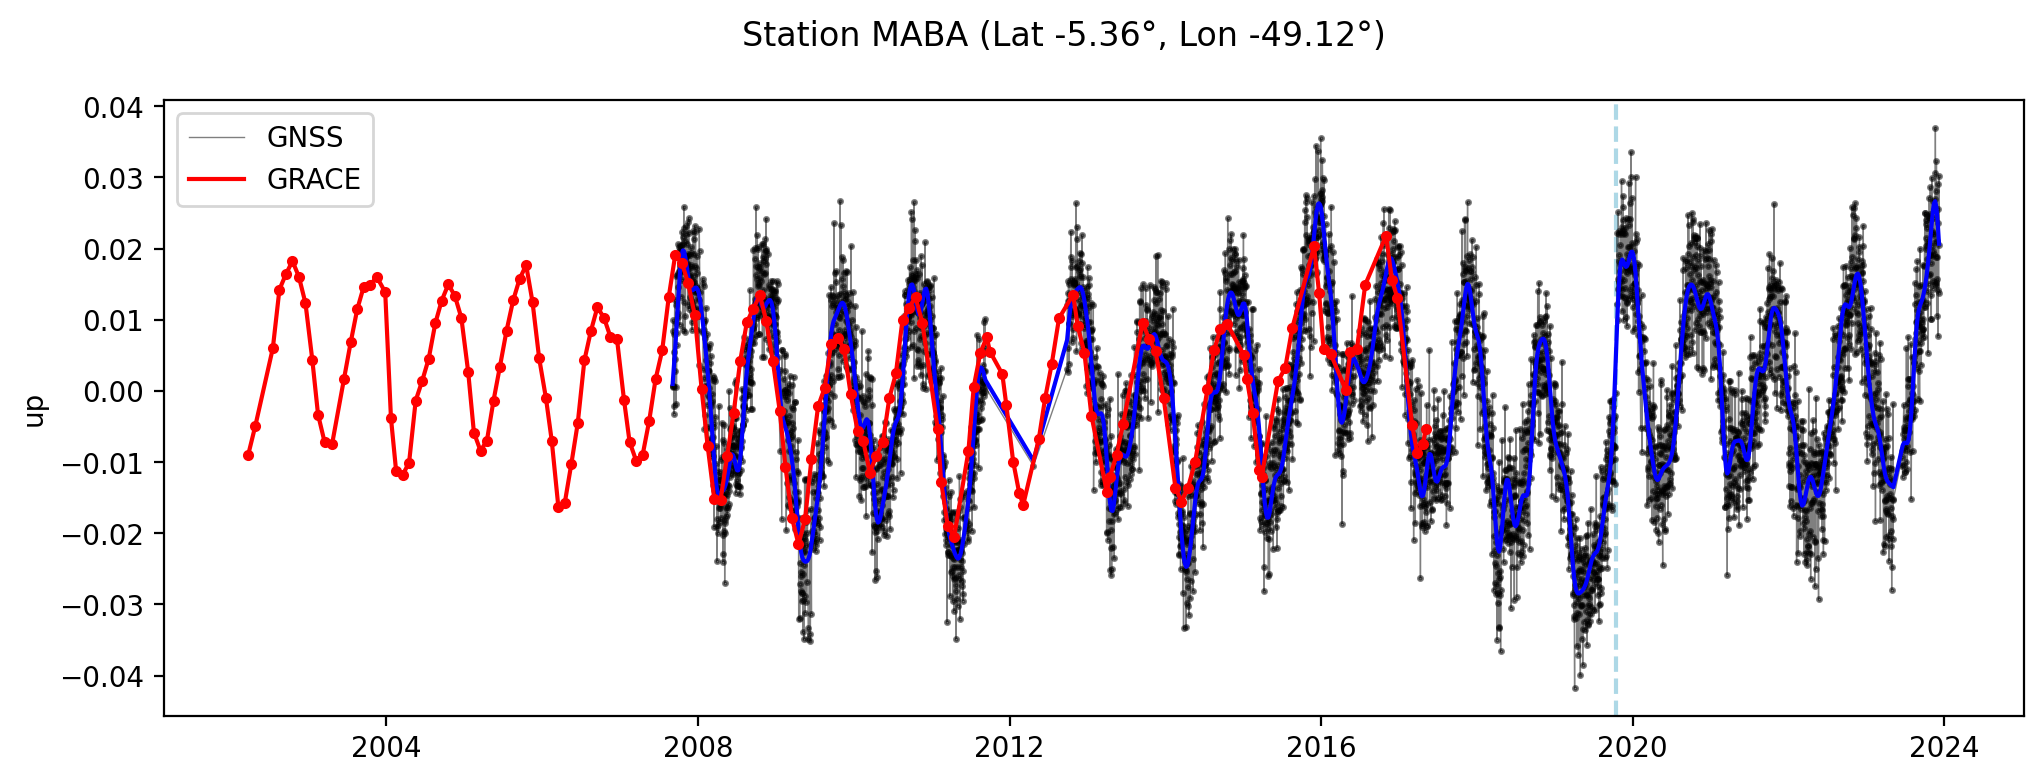

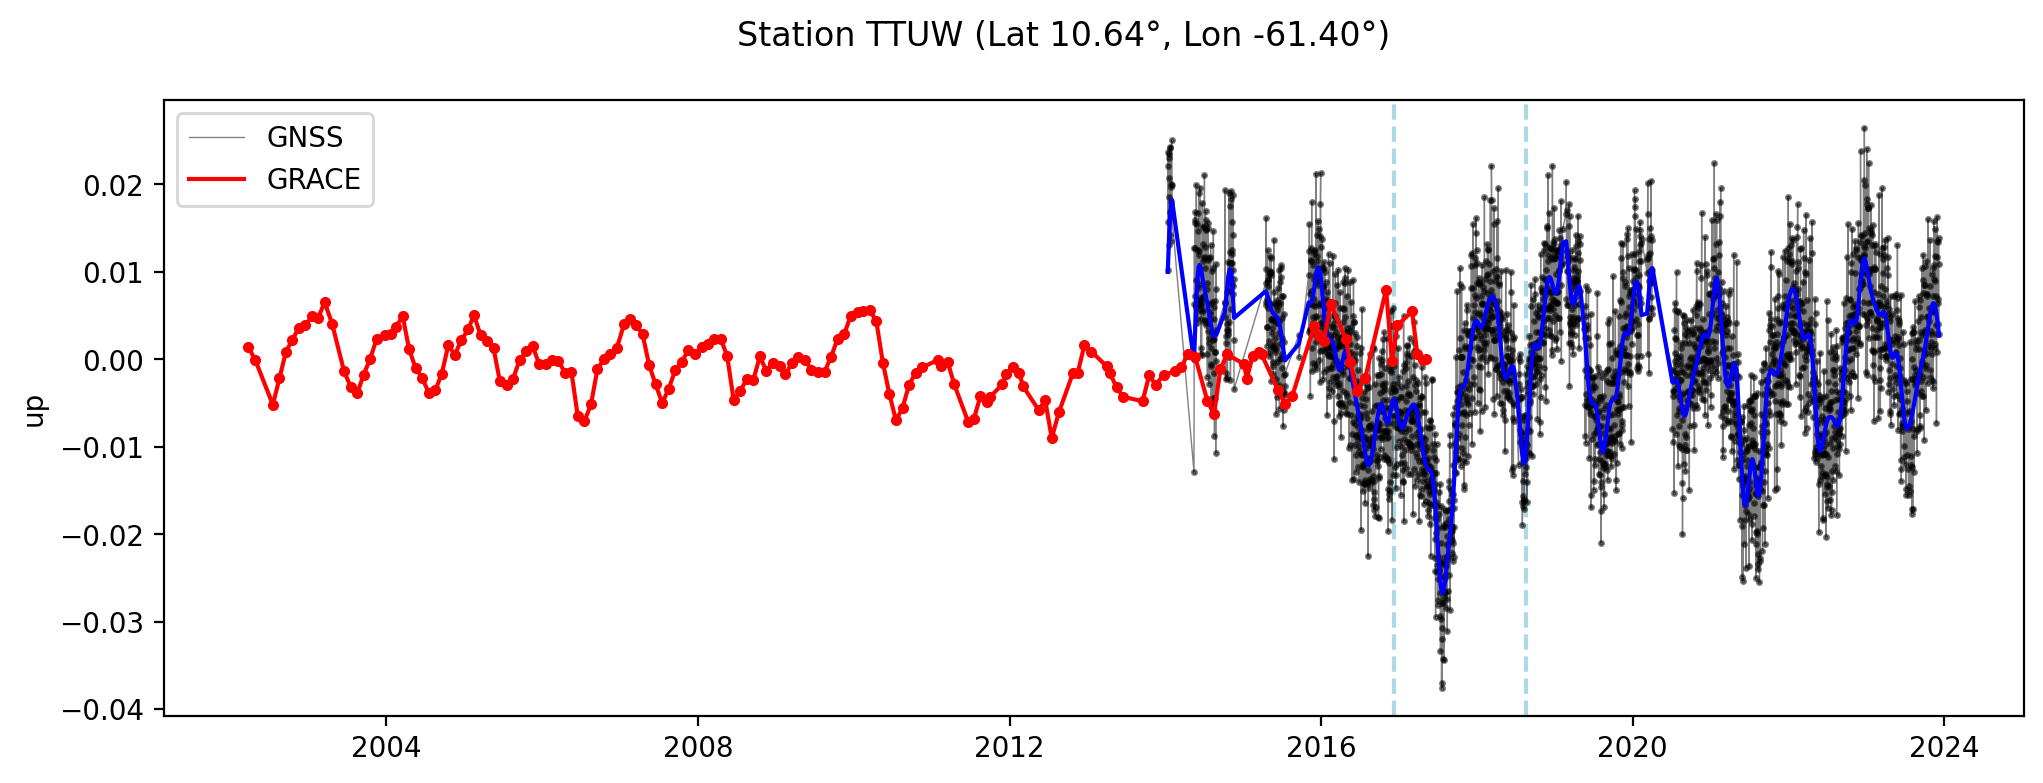

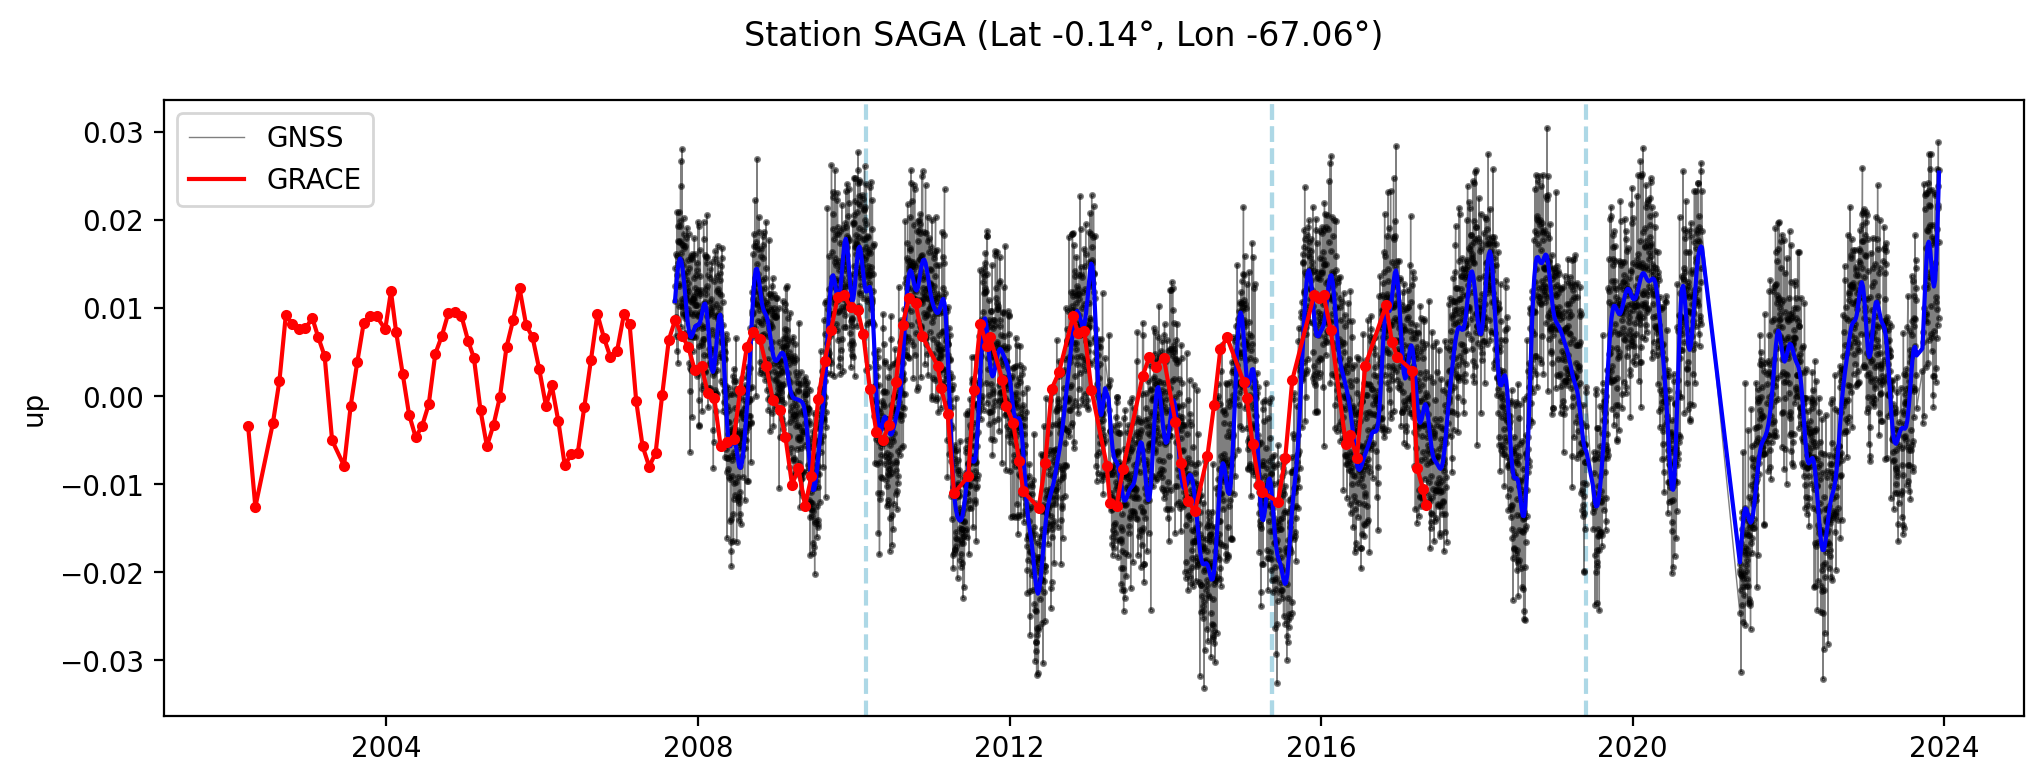

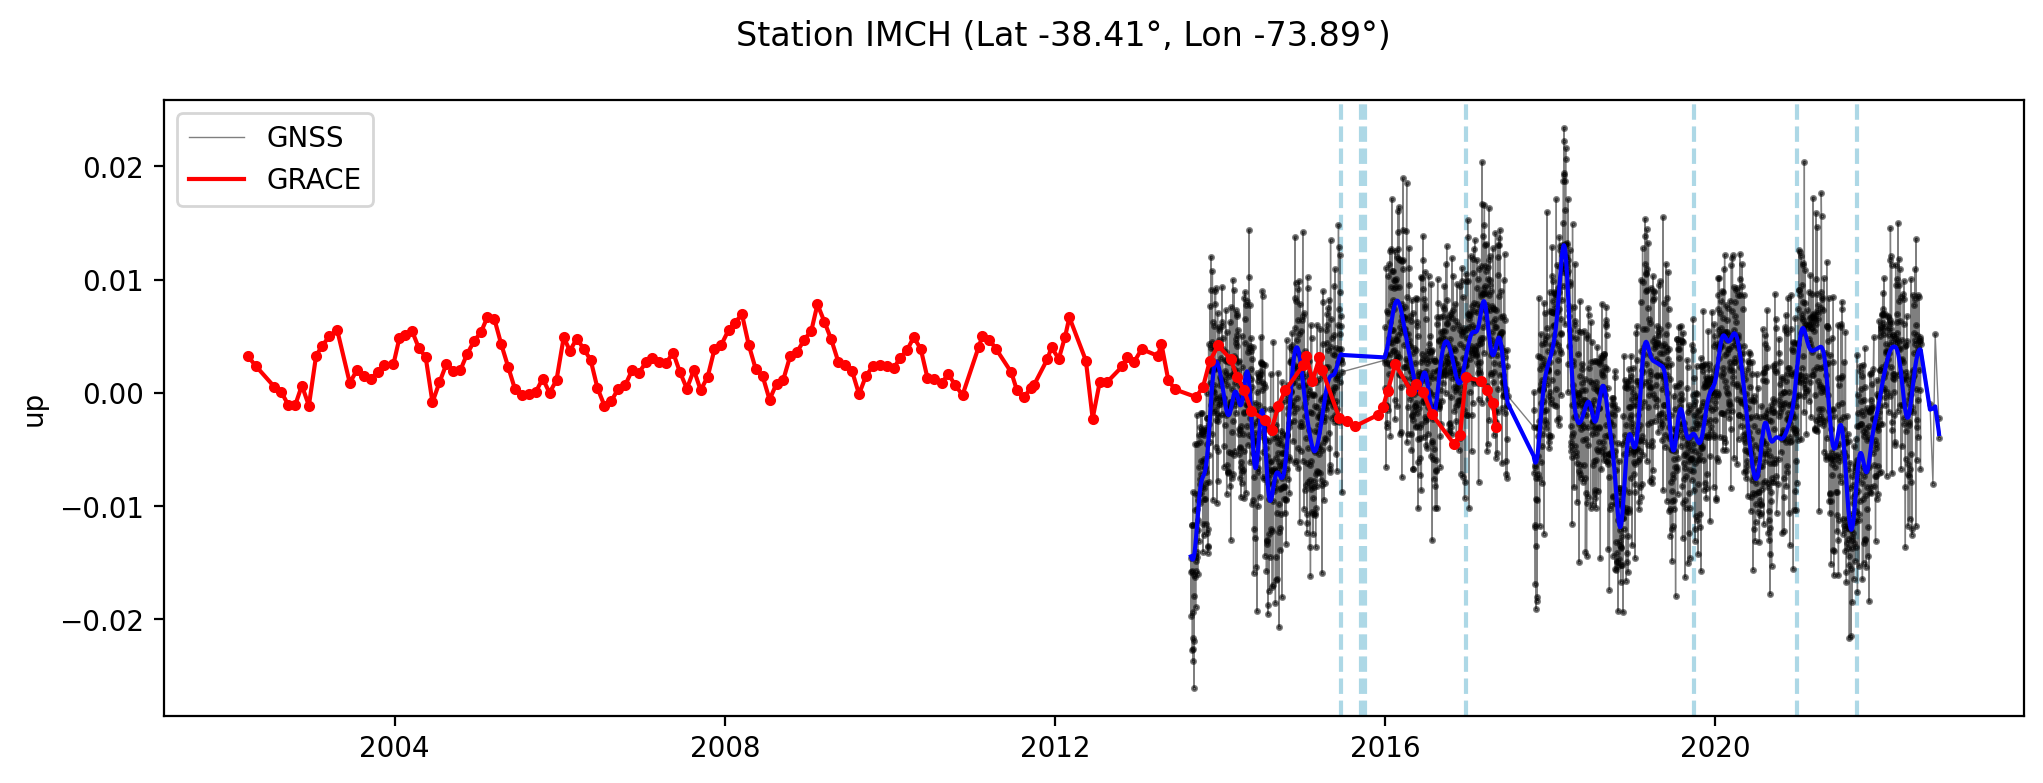

In [26]:
# Plot comparatif pour une station

for station in stations.keys():
    
    grace_data = grace_df.loc[station]
    gnss_data = gnss_df.loc[station]
    gnss_steps_data = gnss_steps.loc[station]

    # Recaler les deux mesures : on retire leur moyenne sur la periode commune 
    dt1 = max(gnss_data.index[0].date(),grace_data.index[0])
    dt2 = min(gnss_data.index[-1].date(),grace_data.index[-1])
    i1_gnss, i1_grace = np.abs(gnss_data.index - pd.Timestamp(dt1)).argmin(),np.abs(grace_data.index - dt1).argmin()
    i2_gnss, i2_grace = np.abs(gnss_data.index - pd.Timestamp(dt2)).argmin(),np.abs(grace_data.index - dt2).argmin()
    grace_data -= grace_data.iloc[i1_grace:i2_grace].mean()
    gnss_data -= gnss_data.iloc[i1_gnss:i2_gnss].mean()
            
    # --- 1 composant ---
    cpnt = "up"
    fig, ax = plt.subplots(figsize=plt.figaspect(1/3), dpi=200.)

    ax.plot(gnss_data.index,gnss_data[cpnt+"_detrended"] ,c="k",lw=0.5,alpha=0.5,label="GNSS")
    ax.plot(gnss_data.index,gnss_data[cpnt+"_detrended"] ,c="k",alpha=0.5,marker=".",ls="",ms=3)
    ax.plot(gnss_data.index,gnss_data[cpnt+ "_dt_filtered"] ,c="b")

    ax.plot(grace_data.index, grace_data[cpnt], c="r",label=f"GRACE")
    ax.plot(grace_data.index, grace_data[cpnt], ls="",marker=".",c="r")

    if type(gnss_steps_data["Date"]) == pd.Timestamp:
        ax.axvline(gnss_steps_data["Date"], linestyle='--', color='lightblue', zorder=1)
    elif type(gnss_steps_data["Date"]) == pd.Series:
        for dt in gnss_steps_data["Date"]:
            ax.axvline(dt, linestyle='--', color='lightblue', zorder=1)


    ax.set_ylabel(cpnt)
    ax.legend()
        
    # ax.set_ylim(-0.03, 0.03)

    lat,lon = stations[station]
    fig.suptitle(f"Station {station} (Lat {lat:.2f}°, Lon {lon:.2f}°)")

    plt.savefig(f"../figures/{station}_{cpnt}.png", dpi=100.)

    plt.show()



# Observations : 
- SAGA : signal periodique surimposé
- autres stations (MTCO) : déphasage (données GRACE en avance) -> limites modèle élastique

+ prendre un exemple sur une île 

In [18]:
# # 3 composants
# fig, ax = plt.subplots(3, 1, figsize=plt.figaspect(1), dpi=100.)

# for i,cpnt in enumerate(['up', 'North (m)', 'East (m)']):
        
#     ax[i].plot(gnss_data.index,gnss_data[cpnt] ,c="k",lw=0.5,alpha=0.5,label="GNSS")
#     ax[i].plot(gnss_data.index,gnss_data[cpnt] ,c="k",marker=".",ls="",ms=3)

#     ax[i].plot(grace_data.index, grace_data[cpnt]*10, c="r",label="GRACE")
#     ax[i].plot(grace_data.index, grace_data[cpnt]*10, ls="",marker=".",c="r")

#     ax[i].set_ylabel(cpnt)
#     ax[i].legend()

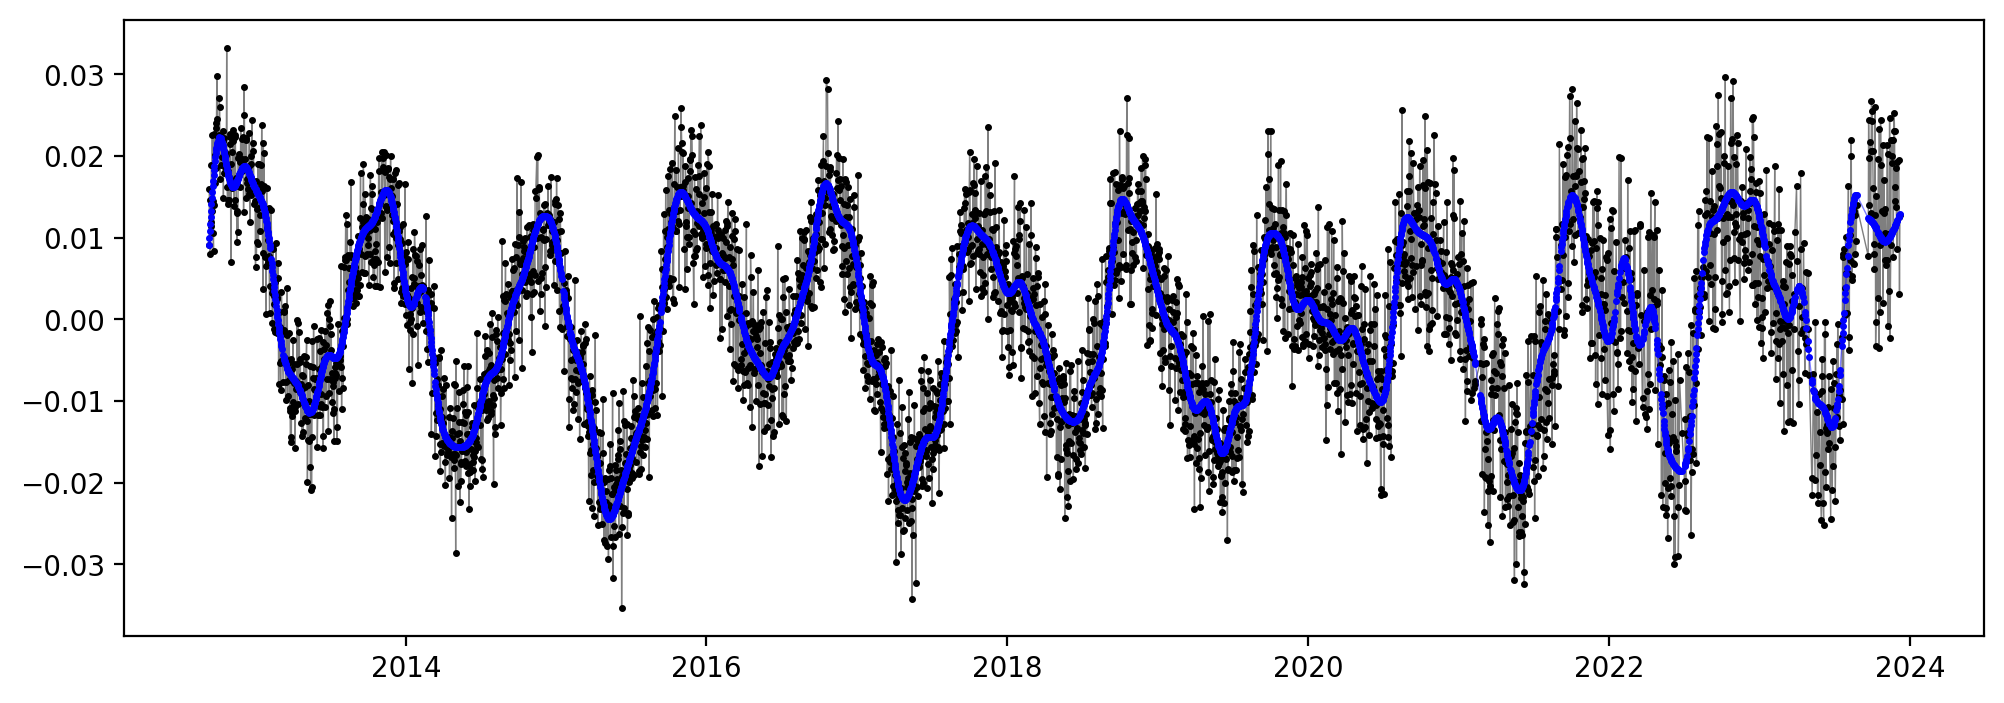

In [17]:
cpnt = "up"
fig, ax = plt.subplots(figsize=plt.figaspect(1/3), dpi=200.)

data = gnss_df.loc["AMCO"]

ax.plot(data.index, data[cpnt+"_detrended"] ,c="k",lw=0.5,alpha=0.5,label="GNSS")
ax.plot(data.index, data[cpnt+"_detrended"] ,c="k",marker=".",ls="",ms=3)

ax.plot(data.index, data[cpnt+"_dt_filtered"] ,c="b",lw=0.5,alpha=0.5,label="GNSS filtered")
ax.plot(data.index, data[cpnt+"_dt_filtered"] ,c="b",marker=".",ls="",ms=3)

plt.show()